## 2023 La Nina Cruise ADCP transect plts and cleanup<br>
This notebook shows zonal and meridional velocity component graphs for the 2023 La Nina Cruise. The goal is to take a look at the data and get it ready for calculating mixing metrics<br>
Note that this notebook utilizes code from Susan Hautala and code inspired by ChatGPT

In [1]:
# Dependencies
import matplotlib.pyplot as plt
import matplotlib as mpl


import numpy as np
import pandas as pd
import xarray as xr
import math
import gsw

import mixsea as mx

In [2]:
mpl.rcParams.update({
    'font.size': 14,           # Default font size
    'axes.labelsize': 14,      # Font size for axis labels
    'axes.titlesize': 16,      # Font size for titles
    'xtick.labelsize': 12,     # Font size for x-axis ticks
    'ytick.labelsize': 12,     # Font size for y-axis ticks
    'legend.fontsize': 12,     # Font size for legend
    'figure.titlesize': 18     # Font size for figure titles
})

In [3]:
# Load ADCP Data
datadir = 'data/2023/adcp' 
filepathadcp = datadir+'/os75nb.nc' # filepath
ADCP_all = xr.open_dataset(filepathadcp, decode_times=False) # open dataset

In [17]:
ADCP_all

<xarray.Dataset>
Dimensions:     (time: 4280, depth_cell: 60)
Coordinates:
  * time        (time) float64 54.89 54.89 54.9 54.9 ... 69.88 69.89 69.89 69.89
Dimensions without coordinates: depth_cell
Data variables: (12/14)
    trajectory  int32 -1713732091
    lon         (time) float64 -157.9 -157.9 -157.9 ... -181.6 -181.6 -181.6
    lat         (time) float64 21.28 21.28 21.28 21.28 ... -18.18 -18.17 -18.16
    depth       (time, depth_cell) float32 ...
    u           (time, depth_cell) float32 ...
    v           (time, depth_cell) float32 ...
    ...          ...
    pflag       (time, depth_cell) int8 ...
    heading     (time) float32 65.86 73.21 73.48 73.46 ... 14.45 14.4 14.24
    tr_temp     (time) float32 24.35 24.43 24.47 24.52 ... 29.06 29.1 29.11 29.1
    num_pings   (time) int16 133 133 132 133 132 133 ... 140 140 141 140 140 141
    uship       (time) float32 nan 0.005516 0.0243 ... 0.9517 0.8969 0.6839
    vship       (time) float32 nan -0.008092 -0.02555 ... 4.317 4.317 3.617
Attributes: (12/13)
    featureType:            trajectoryProfile
    history:                Created: 2024-01-02 06:39:01 UTC
    Conventions:            COARDS CF-1.6
    software:               pycurrents
    hg_changeset:           3274:9f82c3a550a7
    title:                  Shipboard ADCP velocity profiles
    ...                     ...
    cruise_id:              TN413
    sonar:                  os75nb
    yearbase:               2023
    ship_name:              Thomas G. Thompson
    CODAS_variables:        \nVariables in this CODAS short-form Netcdf file ...
    CODAS_processing_note:  \nCODAS processing note:\n======================\...

Let's extract our data from the dataset and remove large NaN gaps that came from os75nb depth limits and masking stationary ADCP data that arise during CTD casts

In [6]:
# find depth_bin to cut all after:
depth = ADCP_all['depth'].T
target_depth = 650 # depth in meters
np.max(depth[:40]) # guess until just greater or lesser than target depth

<xarray.DataArray 'depth' ()>
array(653.)

In [7]:
# this function removes large NaN rows below selected data. i.e., where data gets bad due to os75nb depth limits
def drop_past_dbin(input_data, depth_bin):
    return input_data[:depth_bin] # remove past a selected depth bin

# this function removes large NaN columns that exist throughout all depth bins, handling gaps in data that
# come from when the ship was stationary for CTD casts. i.e., where the ADCP measured the same waters continuously.
def drop_whole_column(input_data):
    mask = np.isnan(input_data)
    cols_to_delete = np.all(mask, axis=0) & (input_data.shape[0] == 40)
    return input_data[:, ~cols_to_delete]

In [9]:
ADCP = ADCP_all.sel(time=slice(62.08, 65.65)) # entire time slice from 5S to 5Nt
v = drop_whole_column(drop_past_dbin(np.array((ADCP['v'].where(ADCP['pflag'] == 0))).T, 40)) # select meridional
u = drop_whole_column(drop_past_dbin(np.array((ADCP['u'].where(ADCP['pflag'] == 0))).T, 40)) # select zonal

lat = np.array(ADCP['lat'].values) # select lats
lat = np.linspace(np.min(lat), np.max(lat), len(v.T)) # ensure lats are in the right shape for use as contourf input
# this is fine because v and u depth bins are also linearly spaced

z = drop_past_dbin(np.array((ADCP['depth'].values)).T, 40) # select depths
z = (z.T[:len(v.T)]).T # as depths are the same across rows, we can set n cols = n cols in v
z = np.linspace(np.min(z), math.floor(np.max(z) / 10.0) * 10, len(z)) # ensure z is the right shape 
# for use as contourf input. this is fine because v and u depth bins are also linearly spaced 
# note that the math.ceil function is used to round 748.9 to 750 for ease of compatability with CTD casts

In [22]:
z

array([ 28.95999908,  44.88410167,  60.80820426,  76.73230685,
        92.65640943, 108.58051202, 124.50461461, 140.4287172 ,
       156.35281979, 172.27692237, 188.20102496, 204.12512755,
       220.04923014, 235.97333272, 251.89743531, 267.8215379 ,
       283.74564049, 299.66974307, 315.59384566, 331.51794825,
       347.44205084, 363.36615342, 379.29025601, 395.2143586 ,
       411.13846119, 427.06256377, 442.98666636, 458.91076895,
       474.83487154, 490.75897412, 506.68307671, 522.6071793 ,
       538.53128189, 554.45538447, 570.37948706, 586.30358965,
       602.22769224, 618.15179482, 634.07589741, 650.        ])

In [10]:
max_rounded = math.floor(np.max(z) / 10.0) * 10
max_rounded

650

In [11]:
np.shape(v)

(40, 630)

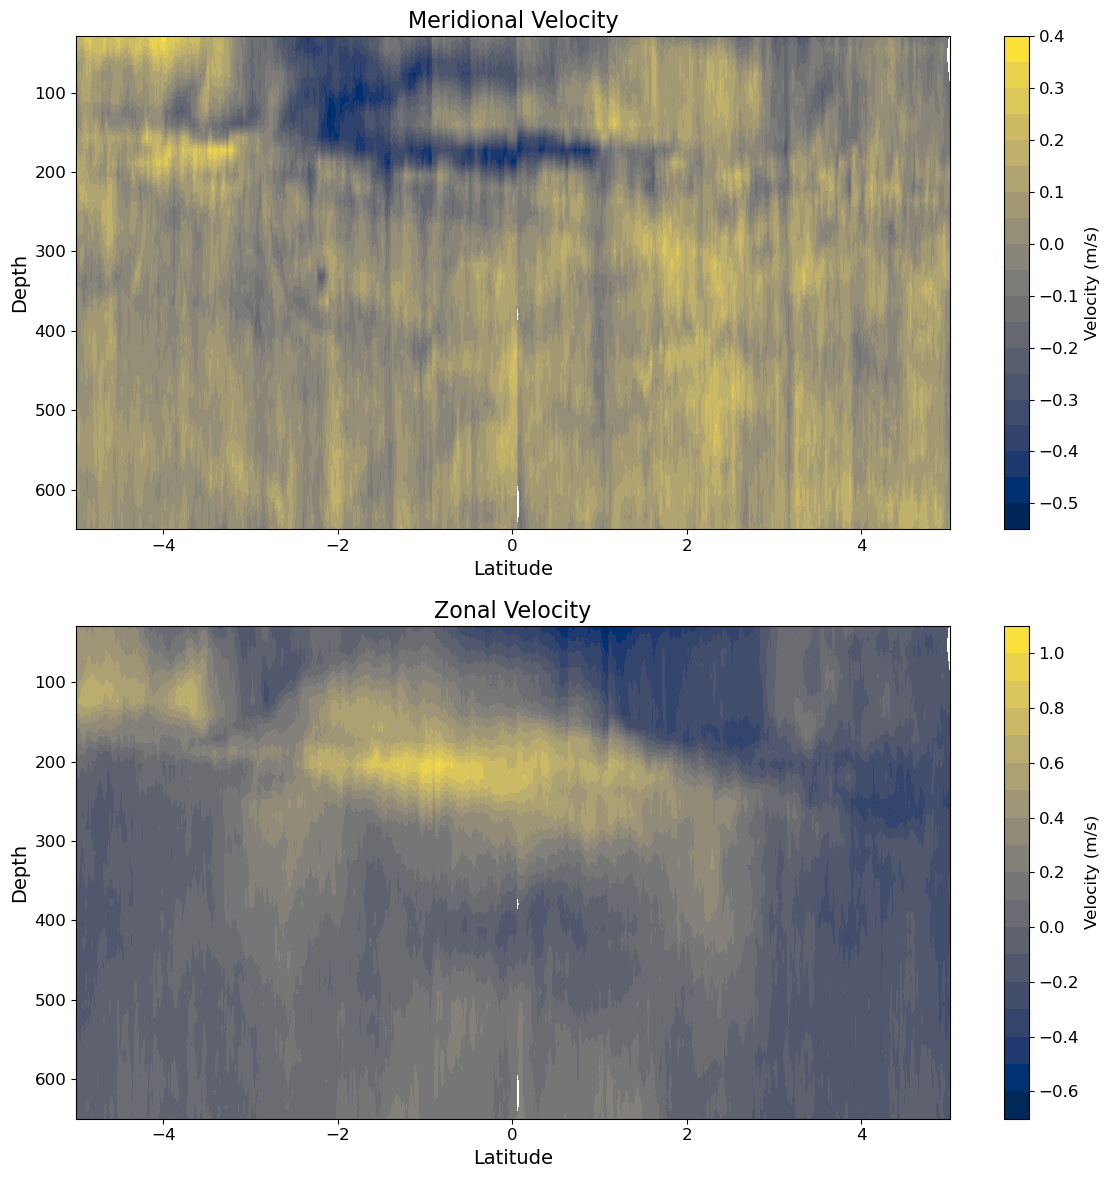

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# meridional velocity
contour1 = ax1.contourf(lat, z, v, levels=20, cmap='cividis')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Depth')
colorbar1 = plt.colorbar(contour1, ax=ax1)
colorbar1.set_label('Velocity (m/s)', fontsize=12)
ax1.set_title('Meridional Velocity')
ax1.invert_yaxis()

# zonal
contour2 = ax2.contourf(lat, z, u, levels=20, cmap='cividis')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Depth')
colorbar2 = plt.colorbar(contour2, ax=ax2)
colorbar2.set_label('Velocity (m/s)', fontsize=12)
ax2.set_title('Zonal Velocity')
ax2.invert_yaxis()

plt.tight_layout()

Let's save the cleaned ADCP data as a netcdf file

In [13]:
data = {
    'u': xr.DataArray(u, dims=('time', 'depth_cell')),  # Assuming u has dimensions (time, depth)
    'v': xr.DataArray(v, dims=('time', 'depth_cell')),  # Assuming v has dimensions (time, depth)
    'z': xr.DataArray(z, dims=('time',)),  # Assuming z has dimensions (time, depth)
    'lat': xr.DataArray(lat, dims=('depth_cell',))  # Assuming lat has dimension (time,)
}
uvz_lat = xr.Dataset(data)

# Save the Dataset to a NetCDF file
uvz_lat.to_netcdf('data/2023/adcp/2023_os75nb_cleaned.nc')